In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from glob import glob
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

In [2]:
IMG_SIZE = 224
BATCH_SIZE = 32
CHANNELS = 3
EPOCH = 20

In [6]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "data-set",
    shuffle=True,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)

Found 748 files belonging to 4 classes.


In [7]:
class_names = dataset.class_names
class_names

['acne', 'dry', 'normal', 'oily']

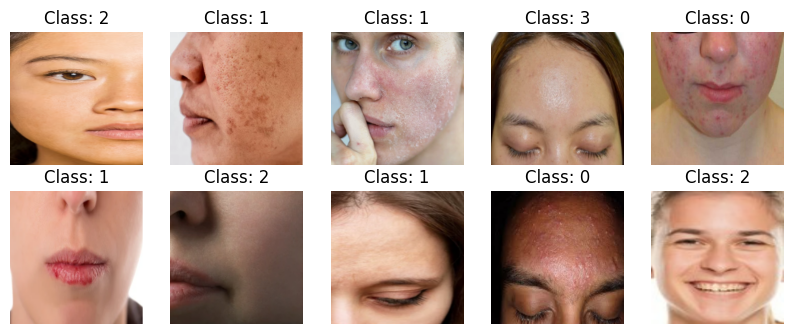

In [8]:
def display_first_10_images(dataset):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):
        for i in range(10):
            ax = plt.subplot(5, 5, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(f'Class: {labels[i].numpy()}')
            plt.axis("off")

display_first_10_images(dataset)
plt.show()

In [9]:
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

In [10]:
train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size).take(val_size)
test_dataset = dataset.skip(train_size).skip(val_size)

In [11]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

In [12]:
test_datagen = ImageDataGenerator(rescale = 1./255)

In [13]:
validation_datagen = ImageDataGenerator(rescale = 1./255)

In [14]:
import os
import shutil

# Define a function to save the dataset to disk
def save_dataset_to_disk(dataset, directory, class_names):
    for i, (image, label) in enumerate(dataset):
        for j in range(len(image)):
            # Get the class name corresponding to the label
            class_name = class_names[label[j].numpy()]
            # Create class directories if not exist
            class_directory = os.path.join(directory, class_name)
            os.makedirs(class_directory, exist_ok=True)
            # Save images to class directories
            filename = os.path.join(class_directory, f"image_{i * 32 + j}.jpg")
            tf.keras.preprocessing.image.save_img(filename, image[j].numpy())

In [15]:
save_dataset_to_disk(train_dataset, 'Splitted Data/Train',class_names)
save_dataset_to_disk(test_dataset, 'Splitted Data/Test',class_names)
save_dataset_to_disk(val_dataset, 'Splitted Data/Validation',class_names)

In [16]:
training_set = train_datagen.flow_from_directory(
    'Splitted Data/Train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 608 images belonging to 4 classes.


In [17]:
testing_set = train_datagen.flow_from_directory(
    'Splitted Data/Test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 76 images belonging to 4 classes.


In [18]:
validation_set = train_datagen.flow_from_directory(
    'Splitted Data/Validation',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 64 images belonging to 4 classes.


In [19]:
vgg = tf.keras.applications.VGG16(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    weights='imagenet',
    include_top=False
)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 25s 0us/step


In [20]:
for layer in vgg.layers:
    layer.trainable = False

In [21]:
x = layers.Flatten()(vgg.output)
prediction = layers.Dense(4, activation='softmax')(x)

In [22]:
model = tf.keras.models.Model(inputs=vgg.input, outputs=prediction)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4)                   │         100,356 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 14,815,044 (56.51 MB)

 Trainable params: 100,356 (392.02 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [23]:
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [24]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCH
)

Epoch 1/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 262s 14s/step - accuracy: 0.4283 - loss: 16.2469 - val_accuracy: 0.7188 - val_loss: 5.3535
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 263s 14s/step - accuracy: 0.8372 - loss: 3.3332 - val_accuracy: 0.8906 - val_loss: 1.3492
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 247s 13s/step - accuracy: 0.9263 - loss: 0.7601 - val_accuracy: 0.9375 - val_loss: 0.6063
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 261s 13s/step - accuracy: 0.9576 - loss: 0.4795 - val_accuracy: 0.9531 - val_loss: 0.2459
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 244s 13s/step - accuracy: 0.9772 - loss: 0.1517 - val_accuracy: 0.9844 - val_loss: 0.0435
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 244s 13s/step - accuracy: 0.9740 - loss: 0.2709 - val_accuracy: 1.0000 - val_loss: 8.7326e-06
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 262s 13s/step - accuracy: 0.9880 - loss: 0.0834 - val_accuracy: 1.0000 - val_loss: 1.1086e-05
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 243s 13s/step - accuracy: 0.9869 - loss: 0.1531 - val_acc

In [25]:
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 28s 8s/step - accuracy: 1.0000 - loss: 0.0000e+00 
Test Accuracy: 1.0


In [26]:
val_loss, val_acc = model.evaluate(val_dataset)
print(f"validation Accuracy: {val_acc}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 25s 11s/step - accuracy: 1.0000 - loss: 8.6673e-07
validation Accuracy: 1.0


First image to predict


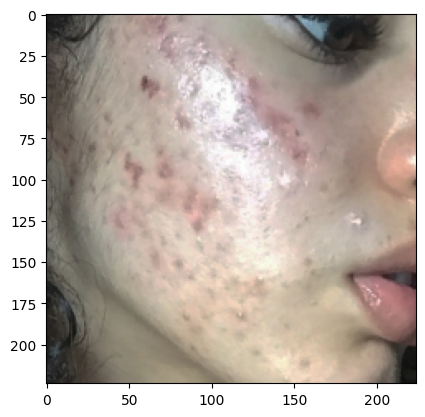

Actual label: acne
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
Predicted label: acne


In [27]:
import numpy as np

# Shuffle the test dataset
test_dataset_shuffled = test_dataset.shuffle(buffer_size=test_size)

for images_batch, labels_batch in test_dataset_shuffled.take(1):
    # Visualize the first image in the batch
    firstImg = images_batch[2].numpy().astype('uint8')
    firstLabel = labels_batch[2].numpy()
    
    print("First image to predict")
    plt.imshow(firstImg)
    plt.show()  # Display the image
    print("Actual label:", class_names[firstLabel])
    
    # Predict the label for the first image
    batch_prediction = model.predict(images_batch)
    predicted_label = np.argmax(batch_prediction[0])
    print("Predicted label:", class_names[predicted_label])

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

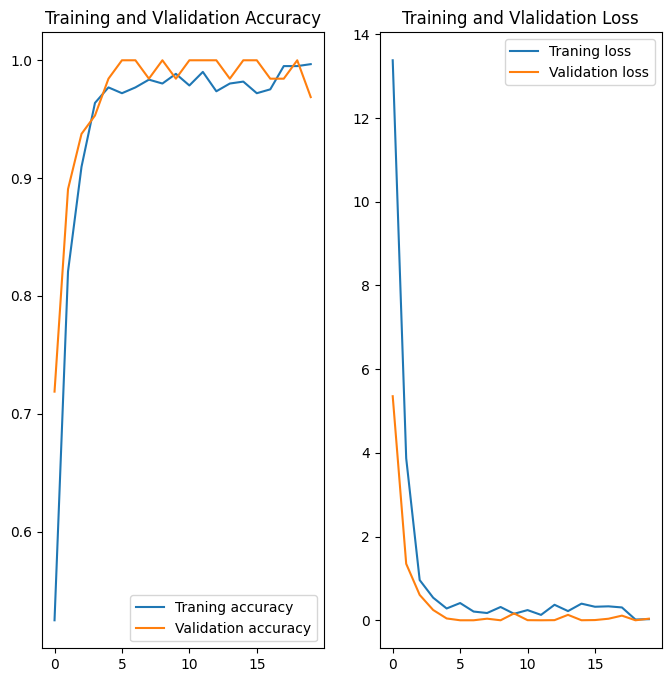

In [29]:
plt.figure(figsize=(8,8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCH), acc, label='Traning accuracy')
plt.plot(range(EPOCH), val_acc, label='Validation accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Vlalidation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCH), loss, label='Traning loss')
plt.plot(range(EPOCH), val_loss, label='Validation loss')
plt.legend(loc = 'upper right')
plt.title('Training and Vlalidation Loss')
plt.show()

In [30]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array (images[i].numpy())
    img_array = tf. expand_dims(img_array, 0) # Create a batch
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions [0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 981ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 677ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 711ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 751ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 700ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 749ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 715ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 721ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 744ms/step


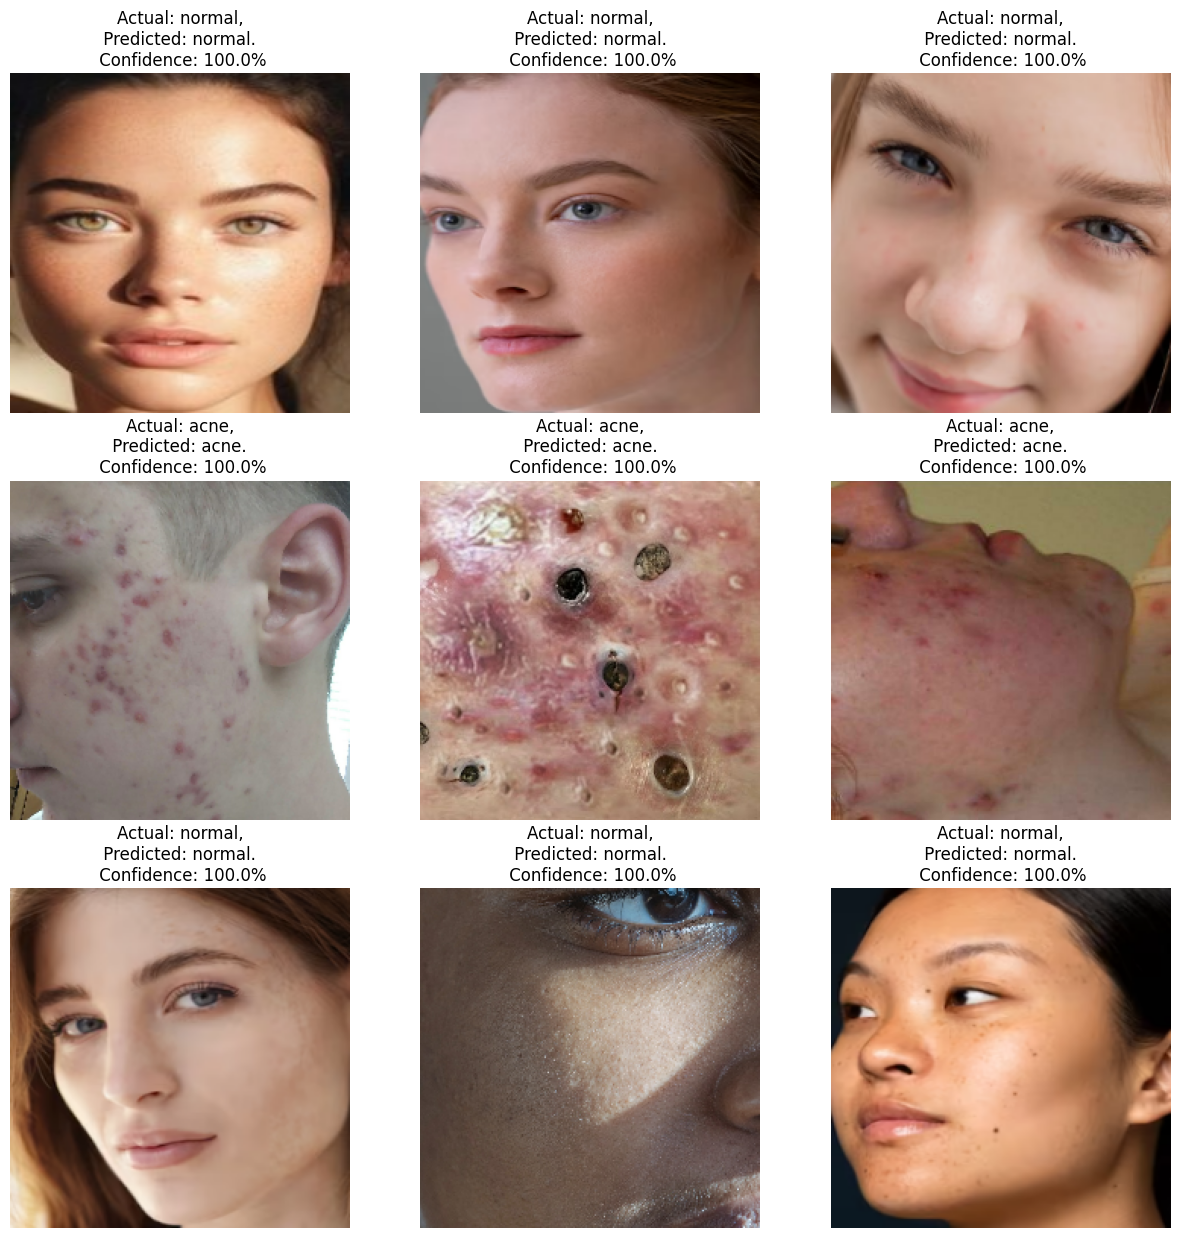

In [31]:
plt.figure(figsize=(15, 15))

for images, labels in test_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())  
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}. \n Confidence: {confidence}%")  
        plt.axis("off")